In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import multiprocessing
import torchvision
import timm
import os
from transformers import *
from datasets import load_dataset
from PIL import Image
from torchinfo import summary
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import time

torch.cuda.empty_cache()
device="cuda" if torch.cuda.is_available() else "cpu"
print(f"Using: {device}")

Using: cuda


### Data Loading and Pretrained models

In [2]:
def image_fetch(src,image_paths):
    l=os.listdir(src)
    if(len(l)!=0):
        for i in range(len(l)):
            if(".jpg" in l[i] or ".jpeg" in l[i] or ".png" in l[i]):
                image_paths.append(str(src+l[i]))
            elif("." not in l[i]):
                try:
                    image_fetch(str(src+l[i]+"/"),image_paths)
                except:
                    continue
                            
def class_fetch(image_paths)->(list,dict):
    s=set()
    for i in image_paths:
        s.add(i.split("/")[-2])
    d={}
    count=0
    for i in s:
        d[i]=count
        count+=1
    return list(s),d

In [3]:
class modified_dataset_loader(Dataset):
    
    def __init__(self,targ_dir=None,paths=None,transformations=None):

        if(targ_dir!=None):
            self.transform=transformations
            self.paths=[]
            image_fetch(targ_dir,self.paths)
            self.classes, self.class_to_idx=class_fetch(self.paths)
        else:
            self.transform=transformations
            self.paths=paths
            self.classes, self.class_to_idx=class_fetch(self.paths)
            


    def load_image(self,index)-> Image.Image:
        image_path=self.paths[index]
        return Image.open(image_path).convert('RGB')

    def __len__(self):
        return len(self.paths)

    def __getitem__(self,index):
        image=self.load_image(index)
        class_val=self.class_to_idx[(self.paths[index]).split("/")[-2]]
        if(self.transform):
            image=self.transform(image)
        return image,class_val

In [4]:
batch_size=4
cpu_count=multiprocessing.cpu_count()
model_name="vit_base_patch16_384.orig_in21k_ft_in1k"

model = timm.create_model(model_name, pretrained=True)

data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

transform_data=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                              torchvision.transforms.Resize(size=(384,384))])

data_path=[]
image_fetch("../sample_small_dataset/Train/",data_path)

train,test=train_test_split(data_path,test_size=0.5)
test,val=train_test_split(test,test_size=0.5)

train_data=modified_dataset_loader(paths=train,transformations=transform_data)
test_data=modified_dataset_loader(paths=test,transformations=transform_data)
val_data=modified_dataset_loader(paths=val,transformations=transform_data)

print(f"No. of images in Training set: {len(train)}\nNo. of images in Validation set: {len(val)}\nNo. of images in Test set: {len(test)}")

No. of images in Training set: 266
No. of images in Validation set: 134
No. of images in Test set: 133


In [5]:
train_loader=torch.utils.data.DataLoader(train_data,shuffle=True,batch_size=batch_size,num_workers=cpu_count)
test_loader=torch.utils.data.DataLoader(test_data,shuffle=True,batch_size=batch_size,num_workers=cpu_count)
val_loader=torch.utils.data.DataLoader(val_data,shuffle=True,batch_size=batch_size,num_workers=cpu_count)

### Freezing layers and slight modification to model

In [6]:
count=0
for param in model.parameters(): #152 layers
    if(count>=100):
        break
    param.requires_grad=False
    count+=1


### Needs to be configured for LSTM
class modified_model(torch.nn.Module):
    def __init__(self,model,out_features,modify_bool=True,add_block_dropout_bool=True):
        super(modified_model,self).__init__()
        self.model=model
        self.model_in_features=model.head.in_features
        self.model.head=nn.Linear(in_features=self.model_in_features,out_features=out_features)
        self.modify_bool=modify_bool
        self.add_block_dropout_bool=add_block_dropout_bool

        
        def add_block_dropouts():
            for i in range(len(self.model.blocks)):
                self.model.blocks[i].mlp.drop2=nn.Dropout(p=(torch.randint(low=0,high=50,size=(1,))/100).item())
        def default_block_dropouts():
            for i in range(len(self.model.blocks)):
                self.model.blocks[i].mlp.drop2=nn.Dropout(p=0)

        def modify():
            self.model.head=nn.Linear(in_features=self.model_in_features,out_features=1000)
            
            self.layer1=nn.Linear(in_features=12,out_features=128)
            self.layer2=nn.Linear(in_features=128,out_features=256)
            self.layer3=nn.Linear(in_features=256,out_features=512)
            self.relu=nn.ReLU();
            
            self.layer_final1=nn.Linear(in_features=(self.model.head.out_features+(self.layer3.out_features)),out_features=1024)
            self.layer_final2=nn.Linear(in_features=1024,out_features=out_features)
        if(self.add_block_dropout_bool):
            add_block_dropouts()
        else:
            default_block_dropouts()
        if(self.modify_bool):
            modify()

    
    def forward(self,x,y=None):
            if(self.modify_bool and y!=None):
                self.result_month=self.layer3(self.relu(self.layer2(self.relu(self.layer1(y)))))
                self.result_model=self.model(x)
                combination=torch.hstack((self.result_month,self.result_model.squeeze()))
                return self.layer_final2(self.relu(self.layer_final1(combination)))
            else:
                return self.model(x)


class simple_cnn(nn.Module):
    def __init__(self,total_classes=2):
        super().__init__()
        #[(W−K+2P)/S]+1
        
        # 384 x 384 x 3
        self.input_layer=nn.Conv2d(in_channels=3,out_channels=128,kernel_size=(3,3),stride=1,padding=1,padding_mode="replicate",bias=True)
        # 384 x 384 x 128
        self.relu1=nn.ReLU()
        self.layer1=nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(3,3),stride=1)
        self.maxpool1=nn.MaxPool2d(kernel_size=(3,3),stride=1)
        # 190 x 190 x 256
        
        self.relu2=nn.ReLU()
        self.layer2=nn.Conv2d(in_channels=256,out_channels=128,kernel_size=(4,4),stride=1)
        self.maxpool2=nn.MaxPool2d(kernel_size=(4,4),stride=2)
        # 92 x 92 x 512

        self.relu3=nn.ReLU()
        self.layer3=nn.Conv2d(in_channels=128,out_channels=10,kernel_size=(3,3),stride=1)
        self.maxpool3=nn.MaxPool2d(kernel_size=(4,4),stride=2)
        # 44 x 44 x 1024

        
        self.flatten_layer=nn.Flatten()
        self.classification_head=nn.Sequential(nn.Linear(in_features=91*91*10,out_features=512),
                                              nn.ReLU(),
                                              nn.Linear(in_features=512,out_features=128),
                                              nn.ReLU(),
                                              nn.Linear(in_features=128,out_features=total_classes))
    def forward(self,x):
        self.convolution_output=self.flatten_layer(self.maxpool3(self.layer3(self.relu3(self.maxpool2(self.layer2(self.relu2(self.maxpool1(self.layer1(self.relu1(self.input_layer(x)))))))))))
        self.net_output=self.classification_head(self.convolution_output)
        return self.net_output

In [7]:
#model=modified_model(model,len(train_data.classes),modify_bool=False,add_block_dropout_bool=True).to(device)
model=simple_cnn(len(train_data.classes)).to(device)

In [8]:
timm.list_models("*mobile*",pretrained=True)

['mobilenetv2_050.lamb_in1k',
 'mobilenetv2_100.ra_in1k',
 'mobilenetv2_110d.ra_in1k',
 'mobilenetv2_120d.ra_in1k',
 'mobilenetv2_140.ra_in1k',
 'mobilenetv3_large_100.miil_in21k',
 'mobilenetv3_large_100.miil_in21k_ft_in1k',
 'mobilenetv3_large_100.ra_in1k',
 'mobilenetv3_rw.rmsp_in1k',
 'mobilenetv3_small_050.lamb_in1k',
 'mobilenetv3_small_075.lamb_in1k',
 'mobilenetv3_small_100.lamb_in1k',
 'mobileone_s0.apple_in1k',
 'mobileone_s1.apple_in1k',
 'mobileone_s2.apple_in1k',
 'mobileone_s3.apple_in1k',
 'mobileone_s4.apple_in1k',
 'mobilevit_s.cvnets_in1k',
 'mobilevit_xs.cvnets_in1k',
 'mobilevit_xxs.cvnets_in1k',
 'mobilevitv2_050.cvnets_in1k',
 'mobilevitv2_075.cvnets_in1k',
 'mobilevitv2_100.cvnets_in1k',
 'mobilevitv2_125.cvnets_in1k',
 'mobilevitv2_150.cvnets_in1k',
 'mobilevitv2_150.cvnets_in22k_ft_in1k',
 'mobilevitv2_150.cvnets_in22k_ft_in1k_384',
 'mobilevitv2_175.cvnets_in1k',
 'mobilevitv2_175.cvnets_in22k_ft_in1k',
 'mobilevitv2_175.cvnets_in22k_ft_in1k_384',
 'mobilevitv

In [9]:
m1=timm.create_model("mobilenetv3_small_100.lamb_in1k",pretrained=True)

model.safetensors:   0%|          | 0.00/10.2M [00:00<?, ?B/s]

In [10]:
m1

MobileNetV3(
  (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): Hardswish()
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
        (bn1): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): ReLU(inplace=True)
          (conv_expand): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (gate): Hardsigmoid()
        )
        (conv_pw): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          

In [8]:
# 384 x 384 x 3
input_layer=nn.Conv2d(in_channels=3,out_channels=128,kernel_size=(3,3),stride=1,padding=1,padding_mode="replicate",bias=True)
# 384 x 384 x 128
relu1=nn.ReLU()
layer1=nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(3,3),stride=1)
maxpool1=nn.MaxPool2d(kernel_size=(3,3),stride=1)
# 190 x 190 x 256

relu2=nn.ReLU()
layer2=nn.Conv2d(in_channels=256,out_channels=256,kernel_size=(4,4),stride=1)
maxpool2=nn.MaxPool2d(kernel_size=(4,4),stride=2)
# 92 x 92 x 512

relu3=nn.ReLU()
layer3=nn.Conv2d(in_channels=256,out_channels=10,kernel_size=(3,3),stride=1)
maxpool3=nn.MaxPool2d(kernel_size=(4,4),stride=2)

print(maxpool3(layer3(maxpool2(layer2(maxpool1(layer1(input_layer(torch.rand(3,384,384)))))))).shape)

torch.Size([10, 91, 91])


### Slight Visualizing

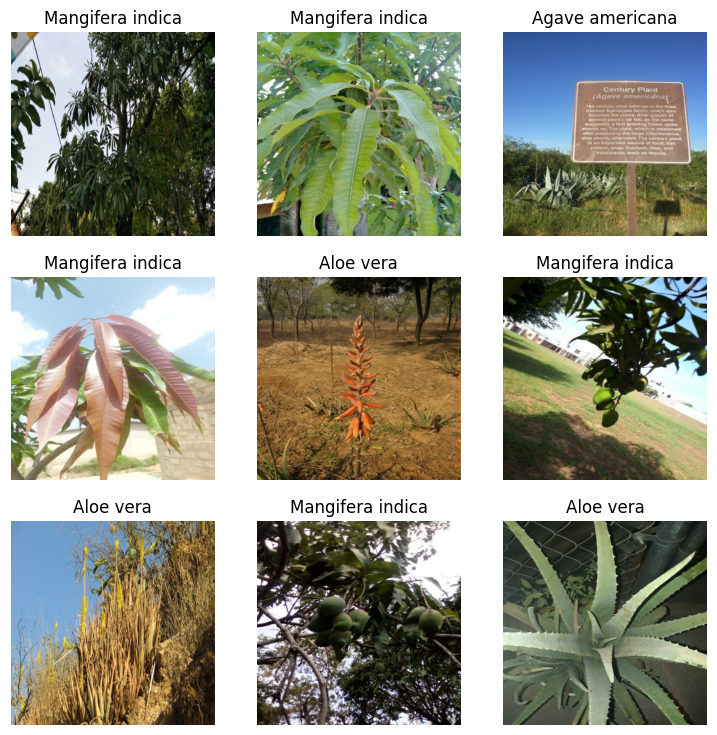

In [9]:
plt.figure(figsize=(9,9))
plt.axis(False)
for i in range(1,10):
    rand_ind=torch.randint(0,batch_size-1,size=(1,)).item()
    data=next(iter(train_loader))
    label=data[1][rand_ind]
    image=data[0][rand_ind].permute(1,2,0)
    plt.subplot(3,3,i)
    plt.title(train_data.classes[label.item()])
    plt.axis(False)
    plt.imshow(image)
    

### Misc.

In [10]:
optimizer=torch.optim.Adam(model.parameters())
loss_fn=nn.CrossEntropyLoss()

#log_dir = "./"+model_name+"feature_extractor_tensorboard"
#writer = SummaryWriter(log_dir=log_dir)

def accuracy_fn(logits,true):
    return torch.eq(torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze(),true).sum().item()/len(logits)
    

### Testing the model (image)

In [11]:
model.eval()
with torch.inference_mode():
    x,y=next(iter(train_loader))
    x=x.to(device)
    y=y.to(device)
    logits=model(x)
    print(logits)
    print(loss_fn(logits.squeeze(),y))
    print(accuracy_fn(logits,y))

tensor([[-0.0834, -0.0097,  0.0221,  0.0009],
        [-0.0825, -0.0114,  0.0221,  0.0002],
        [-0.0830, -0.0103,  0.0227,  0.0006],
        [-0.0831, -0.0095,  0.0225,  0.0004]], device='cuda:0')
tensor(1.3554, device='cuda:0')
0.75


### Training Loop for image classification

In [ ]:
epochs=10

train_accuracy=[]
val_accuracy=[]
train_loss=[]
val_loss=[]

for i in tqdm(range(epochs)):
    print("Training:")
    model.train()
    
    #Defining accuracy and loss for train and val data
    temp_train_accuracy=[]
    temp_val_accuracy=[]
    temp_train_loss=[]
    temp_val_loss=[]

    net_train_accuracy=0
    net_val_accuracy=0
    net_train_loss=0
    net_val_loss=0
    
    with tqdm(total=len(train_loader)) as pbar:
        for x,y in train_loader:
                x=x.to(device)
                y=y.to(device)
    
                #Calculating model output
                logits=model(x)
    
                #Reseting any old gradient values
                optimizer.zero_grad()
                loss=loss_fn(logits.squeeze(),y)

            
                #Track of metrics        
                accuracy_train=accuracy_fn(logits.type(torch.float32),y)
                temp_train_accuracy.append(accuracy_train)
                temp_train_loss.append(loss.item())
    
                #Back Propogation
                loss.backward()
            
                #Update Parameters
                optimizer.step()
            
                #Progress Bar Update
                pbar.update(1)
        pbar.close()
    #Tensorboard & Metrics for the dataset
    net_train_accuracy=sum(temp_train_accuracy)/len(temp_train_accuracy)
    net_train_loss=sum(temp_train_loss)/len(temp_train_loss)
    train_accuracy.append(net_train_accuracy)
    train_loss.append(net_train_loss)
    #writer.add_scalar("Train Accuracy",net_train_accuracy,i)
    #writer.add_scalar("Train Loss",net_train_loss,i)

    #Evaluation
    print("Testing on validation data:")
    model.eval()

    with tqdm(total=len(val_loader)) as pbar2:
        for x,y in val_loader:
            x=x.to(device)
            y=y.to(device)
            
            #Setting inference mode
            with torch.inference_mode():
                logits=model(x)
                loss=loss_fn(logits.squeeze().type(torch.float32),y)

                #Track of metrics
                accuracy_test=accuracy_fn(logits,y)
                temp_val_accuracy.append(accuracy_test)
                temp_val_loss.append(loss.item())

                #Progress Bar Update
                pbar2.update(1)
        pbar2.close()

    #Tensorboard & Metrics for the dataset
    net_val_accuracy=sum(temp_val_accuracy)/len(temp_val_accuracy)
    net_val_loss=sum(temp_val_loss)/len(temp_val_loss)
    val_accuracy.append(net_val_accuracy)
    val_loss.append(net_val_loss)
    #writer.add_scalar("Val Accuracy",net_val_accuracy,i)
    #writer.add_scalar("Val Loss",net_val_loss,i)

    '''
    #Saving the model
    try:
        os.makedirs(f"./{model_name}_feature_extractor/")
    except Exception as e:
        pass
    torch.save(model.state_dict(),f"./{model_name}_feature_extractor/checkpoint-{i+1}.pth")
    '''
    
    print(f"Epoch {i+1}:\nTrain Accuracy: {net_train_accuracy}  Train Loss: {net_train_loss}  Val Accuracy: {net_val_accuracy}  Val Loss: {net_val_loss}")
    print("\n")

  0%|          | 0/10 [00:00<?, ?it/s]

Training:


  0%|          | 0/67 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 1:
Train Accuracy: 0.26865671641791045  Train Loss: 1.6009894538281568  Val Accuracy: 0.3088235294117647  Val Loss: 1.3791655863032621


Training:


  0%|          | 0/67 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 2:
Train Accuracy: 0.2947761194029851  Train Loss: 1.417277055889813  Val Accuracy: 0.3382352941176471  Val Loss: 1.3745265042080599


Training:


  0%|          | 0/67 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 3:
Train Accuracy: 0.23134328358208955  Train Loss: 1.3979878051957089  Val Accuracy: 0.3382352941176471  Val Loss: 1.3752399788183325


Training:


  0%|          | 0/67 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 4:
Train Accuracy: 0.3246268656716418  Train Loss: 1.3865378365587833  Val Accuracy: 0.34558823529411764  Val Loss: 1.3680238864001106


Training:


  0%|          | 0/67 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 5:
Train Accuracy: 0.3208955223880597  Train Loss: 1.3792395858622308  Val Accuracy: 0.34558823529411764  Val Loss: 1.3695786770652323


Training:


  0%|          | 0/67 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 6:
Train Accuracy: 0.3283582089552239  Train Loss: 1.3766849023192675  Val Accuracy: 0.35294117647058826  Val Loss: 1.364422875292161


Training:


  0%|          | 0/67 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 7:
Train Accuracy: 0.3208955223880597  Train Loss: 1.3771819267699967  Val Accuracy: 0.35294117647058826  Val Loss: 1.363966654328739


Training:


  0%|          | 0/67 [00:00<?, ?it/s]